In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import transforms

In [6]:
class CNN_FMnist(nn.Module):
    def __init__(self, input_channel):
        super(CNN_FMnist, self).__init__()

        self.dw1 = nn.Sequential(
            nn.Conv2d(input_channel, 32, kernel_size=5),
            nn.ReLU(),
        )

        self.dw2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),            
        )

        self.up1 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5) 
        )

        self.up2 = nn.Sequential(            
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channel, kernel_size=5) 
        )

        self.act = nn.Sigmoid()


    def forward(self, x):
        x = self.dw1(x)
        x= self.dw2(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.act(x)
        return x

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

trainset = FashionMNIST(root='~/data',  train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testset = FashionMNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

print(len(train_dl), len(test_dl))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:16<00:00, 1558066.94it/s]


Extracting /home/khoidh/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/khoidh/data/FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 138588.05it/s]


Extracting /home/khoidh/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/khoidh/data/FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:11<00:00, 395725.25it/s]


Extracting /home/khoidh/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/khoidh/data/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 5458108.44it/s]

Extracting /home/khoidh/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/khoidh/data/FashionMNIST/raw

1875 313


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_FMnist(input_channel=1).to(device)

optimizer = Adam(model.parameters(), lr = 0.0001)

loss_fn = nn.MSELoss()

In [8]:
for epoch in range(5):
    model.train()
    tr_total_loss = 0
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img = model(train_img)
        train_loss = loss_fn(gen_img, train_img)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img = model(valid_img)

            valid_loss = loss_fn(gen_img, valid_img)

            va_total_loss += valid_loss.item()

    print(f"Epoch: {epoch} - TrainLoss: {tr_total_loss/len(train_dl)} - ValidLoss: {va_total_loss/len(test_dl)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 117.03it/s]


Epoch: 0 - TrainLoss: 0.5467986229896545 - ValidLoss: 0.5196116474299385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 120.57it/s]


Epoch: 1 - TrainLoss: 0.5194867862701416 - ValidLoss: 0.5157249396601424


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 106.18it/s]


Epoch: 2 - TrainLoss: 0.5172410064856211 - ValidLoss: 0.5142988411191934


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 117.93it/s]


Epoch: 3 - TrainLoss: 0.5162624487876892 - ValidLoss: 0.5136136364060849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 119.94it/s]

Epoch: 4 - TrainLoss: 0.5157316359361013 - ValidLoss: 0.5131806828343449


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.84it/s]


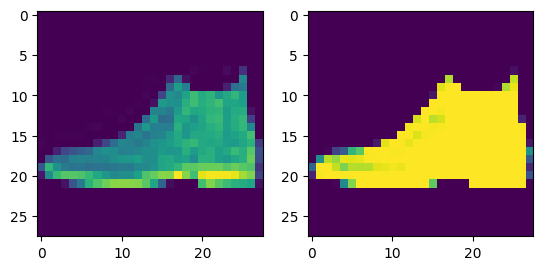

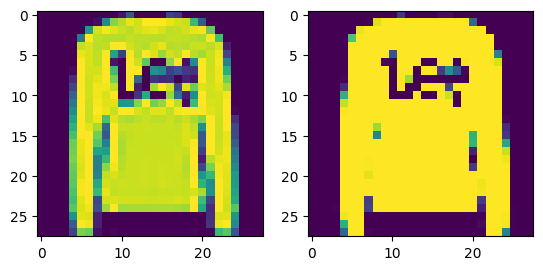

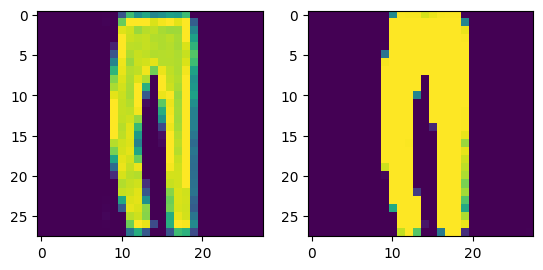

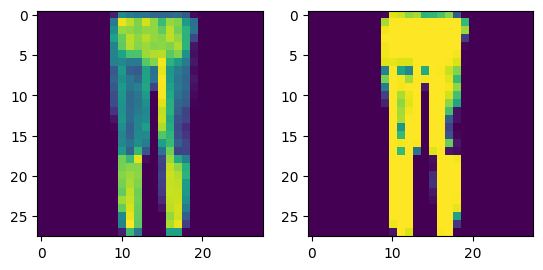

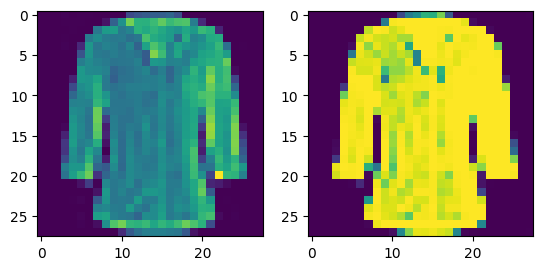

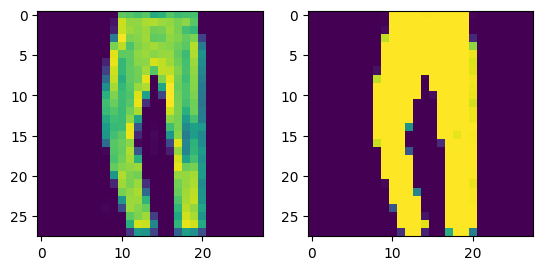

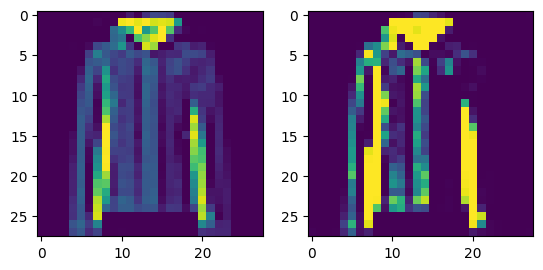

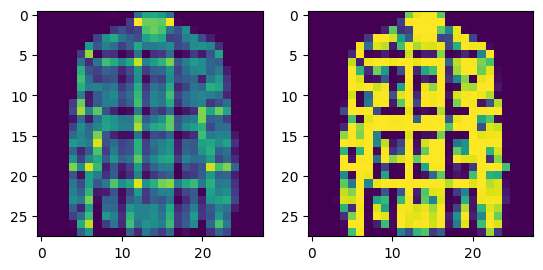

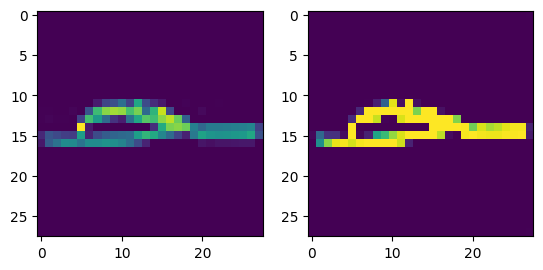

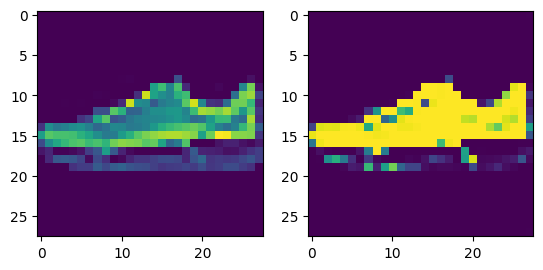

In [9]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = testset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img = model(valid_img)        

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())